In [1]:
import pandas as pd
import numpy as np
from sklearn.externals import joblib
from keras.models import load_model
import pickle

import matplotlib.pylab as plt
%matplotlib inline
plt.style.use('seaborn')

C:\Users\eduardo.hernanz\AppData\Local\Continuum\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
path = '../Entrenamientos/Procesado_Tramos.xlsx'
df = pd.read_excel(path)

In [3]:
#df = df[df["viento_aparente"]!=-np.inf]
df = df[df["porc"]!=np.inf]
#df["puntos_en_tramo"]= df["tramo_final"]-df["tramo_inicial"]
#df = df[df["puntos_en_tramo"]>250]
#df = df[df["porc"]>2]
df = df[df["prueba"]=="20180415_LEVS_195_90_R_E.gpx"]

In [4]:
df.describe()

,tramo,tramo_inicial,tramo_final,pwr,time_seg,dist,spd,viento_aparente,porc,dist_acum
count,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000
mean,65.000000,4062.694656,4122.465649,160.201413,105.961832,821.572519,31.541218,0.184189,-0.092760,56145.359385
std,37.960506,2330.809149,2326.215749,71.193918,169.248538,1169.649683,8.160064,14.381002,2.062240,32025.044386
min,0.000000,0.000000,25.000000,12.155189,1.000000,9.079168,7.249660,-22.370389,-5.830651,324.369941
25%,32.500000,2054.500000,2230.500000,103.356589,22.500000,177.388643,25.498687,-10.595507,-1.070971,29981.215001
50%,65.000000,4226.000000,4246.000000,167.219267,52.000000,433.183923,32.080454,-2.513443,-0.007052,57714.947250
75%,97.500000,6411.000000,6438.000000,216.663213,107.000000,861.307926,37.731686,15.660665,1.395359,87942.209987
max,130.000000,7796.000000,7830.000000,272.274674,1048.000000,7978.285227,52.825966,22.925885,5.452840,107610.184614


In [5]:
df.head()

,tramo,tramo_inicial,tramo_final,pwr,time_seg,dist,spd,viento_aparente,porc,dist_acum,prueba
0,0,0,25,43.429364,49,335.160255,24.624019,17.821092,-2.898980,324.369941,20180415_LEVS_195_90_R_E.gpx
1,1,25,95,210.056487,174,867.319700,17.944546,-2.082980,3.320843,1191.039988,20180415_LEVS_195_90_R_E.gpx
2,2,95,184,96.869255,137,1176.657464,30.919466,-20.637771,-2.378381,2369.369989,20180415_LEVS_195_90_R_E.gpx
3,3,184,200,247.705242,25,239.998902,34.559842,-9.714903,0.502093,2604.239926,20180415_LEVS_195_90_R_E.gpx
4,4,200,201,163.023910,2,18.285419,32.913754,-9.555868,-0.040300,2619.136321,20180415_LEVS_195_90_R_E.gpx


(array([ 1.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  2.,  1.,  1.,  1.,  1.,  0.,  1.,  0.,  2.,
         0.,  1.,  1.,  1.,  3.,  2.,  2.,  1.,  1.,  2.,  0.,  2.,  1.,
         1.,  1.,  0.,  4.,  2.,  3.,  3.,  2.,  2.,  2.,  2.,  8., 10.,
         8.,  5.,  3.,  2.,  4.,  0.,  0.,  1.,  0.,  1.,  2.,  2.,  5.,
         2.,  3.,  2.,  2.,  2.,  0.,  1.,  3.,  0.,  1.,  4.,  0.,  0.,
         2.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.]),
 array([-5.83065104, -5.71781613, -5.60498122, -5.49214632, -5.37931141,
        -5.2664765 , -5.1536416 , -5.04080669, -4.92797178, -4.81513688,
        -4.70230197, -4.58946707, -4.47663216, -4.36379725, -4.25096235,
        -4.13812744, -4.02529253, -3.91245763, -3.79962272, -3.68678781,
        -3.57395291, -3.461118  , -3.34828309, -3.23544819, -3.12261328,
        -3.00977837, -2.89694347, -2.78410856, -2.67127366, -2.558438

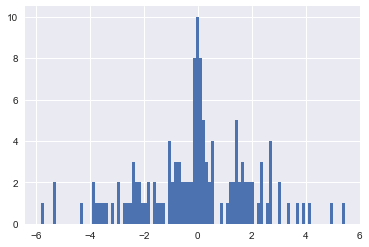

In [7]:
plt.hist(df['porc'],bins=100)

In [28]:
#CON TENSORFLOW
import time
start_time = time.time()

pre_model = joblib.load('../Machine Learning/regr_porc_pwr.model') 

model_TF = load_model('../RNN/TF_Tramos_2.model')
model_Scalar = pickle.load(open("../RNN/Scaler.model", "rb"))



potencia_objetivo = 220
multiplicador_potencia = potencia_objetivo/pre_model.intercept_

resultados = []
fail = 0
exito = 0
num_pruebas = 50
fi = 0


while exito < num_pruebas:
    #print(exito)
    if (fi % 1000) == 0:
        print('Empezamos la prueba %d' %fi)
        print("--- %s seconds ---" % (time.time() - start_time))
    potencia_acum = 0
    tiempo_acum = 0
    i= 0
    lista_tramo_potencia = []
    while i < len(df):
        porc = df[i:i+1]["porc"].iloc[0]
        viento = df[i:i+1]["viento_aparente"].iloc[0]
        distancia = df[i:i+1]["dist"].iloc[0]
        
        #if porc < -2:
        #    potencia = pre_model.predict(porc)[0][0]*multiplicador_potencia+np.random.randint(-abs(porc), abs(porc))
        #elif porc > 2:
        #    #potencia = pre_model.predict(porc)[0][0]+50+np.random.randint(-abs(porc**2), abs(porc**2))
        #    potencia =potencia_objetivo+np.random.randint(0, abs(porc)+50)
        #else:
        #    potencia = potencia_objetivo+np.random.randint(-abs(porc)-10, abs(porc)+30)
        
        #potencia con una sigmoide
        pot_min = 50
        pot_max = 300
        ff_1 = 0.5
        ff_2 = 0.5
        
        potencia = pot_min+(pot_max-pot_min)/(1+ff_1*np.e**(ff_2*porc*-1))+np.random.randint(-10, 10)
        
        
        input_model = model_Scalar.transform([[potencia, porc, viento]])
        
        velocidad = model_TF.predict(input_model)[0]
        
        nuevo_tiempo = distancia/(velocidad/3.6)
        lista_tramo_potencia.append([i, potencia,velocidad[0],distancia,nuevo_tiempo[0],porc,viento])
        
        potencia_acum = potencia_acum + (potencia * nuevo_tiempo)
        tiempo_acum = tiempo_acum + nuevo_tiempo
        
        i += 1
    potencia_media = potencia_acum/tiempo_acum
    print("Intento %d con potencia media %d" %(fi, potencia_media))
    
    if (potencia_media > potencia_objetivo-20) and (potencia_media < potencia_objetivo+20):
        #print(potencia_media, tiempo_acum)
        resultados.append([potencia_media[0], tiempo_acum[0], lista_tramo_potencia])
        exito +=1
    else:
        fail +=1
    
    fi +=1

print("---Total time: %s seconds ---" % (time.time() - start_time))

print('Casos descartados: %d' %fail)
print('Casos de favorables: %d' %(len(resultados)))

C:\Users\eduardo.hernanz\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\base.py:311: UserWarning: Trying to unpickle estimator LinearRegression from version 0.18.1 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\eduardo.hernanz\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\base.py:311: UserWarning: Trying to unpickle estimator RobustScaler from version 0.18.1 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Empezamos la prueba 0
--- 0.7644200325012207 seconds ---
Intento 0 con potencia media 219
Intento 1 con potencia media 218
Intento 2 con potencia media 218
Intento 3 con potencia media 217
Intento 4 con potencia media 219
Intento 5 con potencia media 219
Intento 6 con potencia media 219
Intento 7 con potencia media 219
Intento 8 con potencia media 220
Intento 9 con potencia media 219
Intento 10 con potencia media 219
Intento 11 con potencia media 218
Intento 12 con potencia media 218
Intento 13 con potencia media 219
Intento 14 con potencia media 219
Intento 15 con potencia media 219
Intento 16 con potencia media 218
Intento 17 con potencia media 220
Intento 18 con potencia media 218
Intento 19 con potencia media 219
Intento 20 con potencia media 218
Intento 21 con potencia media 220
Intento 22 con potencia media 220
Intento 23 con potencia media 218
Intento 24 con potencia media 221
Intento 25 con potencia media 218
Intento 26 con potencia media 218
Intento 27 con potencia media 220
I

In [31]:
ds = pd.DataFrame(resultados)
ds.columns = ('pwr','secs','list')

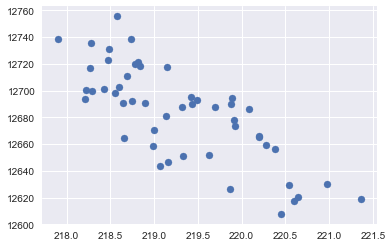

In [32]:
plt.scatter(ds['pwr'],ds['secs'])

(array([1., 0., 0., 0., 2., 3., 0., 1., 2., 3., 2., 2., 2., 2., 1., 2., 1.,
        2., 1., 0., 2., 1., 2., 0., 1., 1., 0., 0., 3., 2., 0., 1., 0., 2.,
        1., 1., 1., 0., 2., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.]),
 array([217.90365601, 217.97283661, 218.04201721, 218.11119781,
        218.18037842, 218.24955902, 218.31873962, 218.38792023,
        218.45710083, 218.52628143, 218.59546204, 218.66464264,
        218.73382324, 218.80300385, 218.87218445, 218.94136505,
        219.01054565, 219.07972626, 219.14890686, 219.21808746,
        219.28726807, 219.35644867, 219.42562927, 219.49480988,
        219.56399048, 219.63317108, 219.70235168, 219.77153229,
        219.84071289, 219.90989349, 219.9790741 , 220.0482547 ,
        220.1174353 , 220.18661591, 220.25579651, 220.32497711,
        220.39415771, 220.46333832, 220.53251892, 220.60169952,
        220.67088013, 220.74006073, 220.80924133, 220.87842194,
        220.94760254, 221.01678314, 221.08596375, 221.15514435,
      

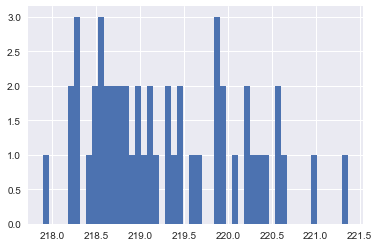

In [33]:
plt.hist(ds['pwr'],bins=50)

In [34]:
min = ds['secs'].min()
ganador = pd.DataFrame(ds[ds['secs']==min]['list'])
ganador

,list
21,"[[0, 122.86021011487344, 44.197742, 335.160255..."


In [36]:
df_ganador = pd.DataFrame(ganador.values[0][0])
df_ganador.columns =[["Tramos","Potencia","Velocidad","Distancia","Tiempo","Pendiente","Viento"]]
df_ganador.to_excel('res_sim.xls')
df_ganador

,Tramos,Potencia,Velocidad,Distancia,Tiempo,Pendiente,Viento
0,0,122.860210,44.197742,335.160255,27.299513,-2.898980,17.821092
1,1,284.304363,23.821793,867.319700,131.071198,3.320843,-2.082980
2,2,138.617733,35.660789,1176.657464,118.784996,-2.378381,-20.637771
3,3,229.986491,30.611853,239.998902,28.224230,0.502093,-9.714903
4,4,206.543479,31.805529,18.285419,2.069688,-0.040300,-9.555868
5,5,219.036236,32.016674,36.784302,4.136079,0.049510,-9.047417
6,6,158.624101,37.539288,1578.833970,151.409439,-2.011362,-9.073735
7,7,245.535850,27.948296,409.440954,52.739792,1.463992,-6.190813
8,8,135.607020,39.363892,894.102341,81.769569,-2.655849,-7.449304
9,9,222.053857,31.521187,32.786633,3.744525,0.234700,-8.247105
